## Import Libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
state = 7
np.random.seed(state)
import random
random.seed(state)

## Exploring Dataset 

In [3]:
df = pd.read_csv('tripadvisor_hotel_reviews.csv')
df.head(10)

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
5,love monaco staff husband stayed hotel crazy w...,5
6,"cozy stay rainy city, husband spent 7 nights m...",5
7,"excellent staff, housekeeping quality hotel ch...",4
8,"hotel stayed hotel monaco cruise, rooms genero...",5
9,excellent stayed hotel monaco past w/e delight...,5


In [4]:
df.isnull().sum()
# No null values present

Review    0
Rating    0
dtype: int64

In [5]:
# Finding length of the longest review.
max_length = len(max(list(df['Review']), key = len))
max_length

13501

In [6]:
# Lets find the average length of reviews
length = []
for i in list(df['Review']):
    length.append(len(i))
    
sum(length)/len(length)

724.896832755844

In [7]:
df['Rating'].value_counts()

5    9054
4    6039
3    2184
2    1793
1    1421
Name: Rating, dtype: int64

Text(0, 0.5, 'Ratings')

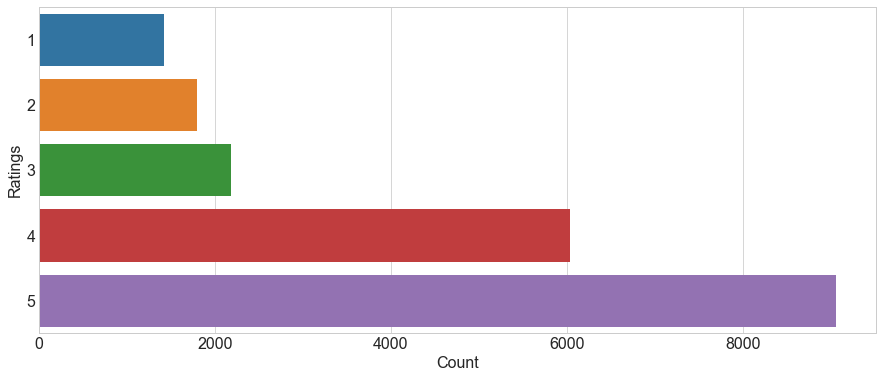

In [8]:
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'font.size': 16})
plt.figure(figsize = (15, 6))
sns.countplot(y = df['Rating'])
plt.xlabel('Count')
plt.ylabel('Ratings')

### Its an imbalanced dataset. We will have to deal with this using class weights to prevent bias towards majority classes.

## Stopwords 

In [9]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stopword = stopwords.words('english')
execption = ['they','them','their','theirs','what','which','who','why', 'how','when','where','how', 'few', 'no','nor','not','can',
             'will',"don't",'should', "should've","aren't",'couldn','only','too','very','don',"aren't",'couldn','but','did',"couldn't",
             "didn't",'doesn',"doesn't", 'hadn',"hadn't",'hasn',"hasn't",'haven',"haven't",'isn',"isn't",'mightn',"mightn't",
             'mustn',"mustn't",'needn', "needn't","shan't",'shouldn',"shouldn't",'wasn',"wasn't",'weren',"weren't","won't",'wouldn',
             "wouldn't",'ain','aren', 'didn', 'don']
stop = [x for x in stopword if x not in execption]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Madridista\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Removed the words present in the 'exception' list from stopwords because these words are important for detecting the sentiment of the reviewer.

## Data preprocessing 

In [10]:
import re
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

In [11]:
def preprocess(X):
    corpus = []
    for i in range(len(X)):
        review = re.sub('[^a-zA-Z]',' ', X[i])
        review = review.lower()
        review = review.split()
        review = [ps.stem(x) for x in review if x not in stop]
        review = ' '.join(review)
        corpus.append(review)
    return corpus

In [12]:
corpus = preprocess(list(df['Review']))

### Cleaned the text by removing non-alphabetical characters, converting all words to lower case and stemming each word. Here PorterStemmer is used for stemming.

## Train test split

In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
y = df['Rating']
X_train, X_test, y_train, y_test = train_test_split(corpus, y, stratify = y, test_size = 0.2, random_state = state)

## TFIDF and Logistic Regression 

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [15]:
# Create Pipeline
# (1, 2) means both unigrams and bigrams
# max_features = 8000 will build a vocabulary of 8000 features

pipe_lr = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range = (1,2), max_features = 8000)),
    ('model', LogisticRegression(class_weight = 'balanced', multi_class = 'ovr'))
])

In [16]:
scores = cross_val_score(pipe_lr, X_train, y_train ,cv = 7, n_jobs = -1)
print('LogisticRegression')
print('Mean Accuracy:', np.round(np.mean(scores) * 100, 2),'%')
print('Standard Deviation:', np.round(np.std(scores) * 100, 2),'%')

LogisticRegression
Mean Accuracy: 61.55 %
Standard Deviation: 0.83 %


In [17]:
pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=8000, ngram_range=(1, 2))),
                ('model',
                 LogisticRegression(class_weight='balanced',
                                    multi_class='ovr'))])

### Since it's an imbalanced dataset, we have used 'stratify' in train_test_split to ensure equal representation of classes in test and train set. The class_weight = “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data. We can either use OneVRestClassifier along with Logistic Regression or mention multi_class = 'ovr' as parameter in Logistic Regression.

## TFIDF and MultinomialNB 

In [18]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier

In [19]:
pipe_nb = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range = (1,2), max_features = 8000)),
    ('model', OneVsRestClassifier(MultinomialNB(), n_jobs = -1))
])

In [20]:
scores = cross_val_score(pipe_nb, X_train, y_train ,cv = 7, n_jobs = -1)
print('MultinomialNB')
print('Mean Accuracy:', np.round(np.mean(scores) * 100, 2),'%')
print('Standard Deviation:', np.round(np.std(scores) * 100, 2),'%')

MultinomialNB
Mean Accuracy: 57.32 %
Standard Deviation: 0.65 %


In [21]:
pipe_nb.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=8000, ngram_range=(1, 2))),
                ('model',
                 OneVsRestClassifier(estimator=MultinomialNB(), n_jobs=-1))])

## Evaluation

### Logistic Regression 

In [22]:
pipe_nb.score(X_test, y_test)

0.5759941449133935

In [23]:
# ROC_AUC_SCORE
from sklearn.metrics import roc_auc_score, plot_confusion_matrix
y_predlr_proba = pipe_lr.predict_proba(X_test)
roc_auc_score(y_test, y_predlr_proba, multi_class = 'ovr')

0.8705488597931342

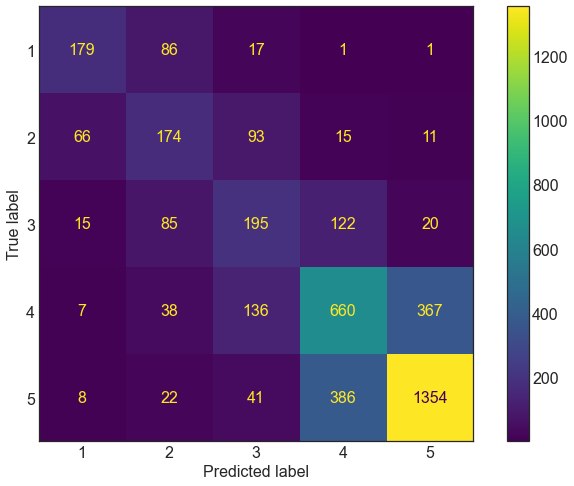

In [24]:
# Confusion Matrix
plt.style.use('seaborn-white')
fig, ax = plt.subplots(figsize = (12, 8))
plot_confusion_matrix(pipe_lr, X_test, y_test, ax = ax)

### MultiNomialNB 

In [25]:
pipe_nb.score(X_test, y_test)

0.5759941449133935

In [26]:
# ROC_AUC_SCORE
from sklearn.metrics import roc_auc_score, plot_confusion_matrix
y_prednb_proba = pipe_nb.predict_proba(X_test)
roc_auc_score(y_test, y_prednb_proba, multi_class = 'ovr')

0.8598208503057719

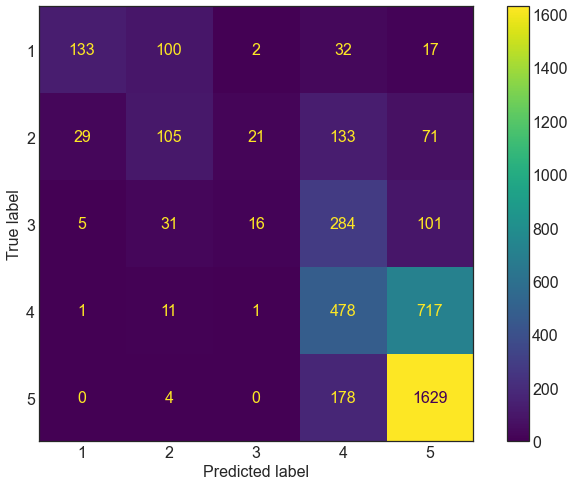

In [27]:
# Confusion Matrix
plt.style.use('seaborn-white')
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize = (12, 8))
plot_confusion_matrix(pipe_nb, X_test, y_test, ax = ax)

### Logistic Regression gives better results for minority classes. Few predictions are present on the immediate right and left of the true label which isn't much of a probelm and very few predictions are present far away from the true label in Logistic Regression.

## Saving pipeline using joblib 

In [28]:
# Save the pipeline
import joblib
joblib.dump(pipe_lr, 'tfidf_model')

['tfidf_model']

In [29]:
# Load the Pipeline
model = joblib.load('tfidf_model')

In [30]:
# Lets try the model on new input.
res = model.predict_proba(preprocess([input()]))
np.argmax(res)+1

Had a very bad experience. The food was not good and the staff were rude to us.


1